
This code is based on: https://github.com/mdeff/cnn_graph and https://nbviewer.jupyter.org/github/mdeff/cnn_graph/blob/outputs/usage.ipynb

Reproducing license notice from https://github.com/mdeff/cnn_graph MIT License

Copyright (c) 2016 Michaël Defferrard

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


In [0]:
!pip install tensorflow-gpu=="1.14"
!pip install numpy matplotlib
!pip install keras

     |████████████████████████████████| 377.0MB 43kB/s 
     |████████████████████████████████| 491kB 66.9MB/s 
     |████████████████████████████████| 3.2MB 70.1MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 1.14.0 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 1.14.0 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0


In [0]:
# Downloading the repo
!git clone https://github.com/Matimath/cnn_graph

Cloning into 'cnn_graph'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 610 (delta 15), reused 20 (delta 7), pack-reused 576
Receiving objects: 100% (610/610), 440.58 KiB | 513.00 KiB/s, done.
Resolving deltas: 100% (386/386), done.


In [0]:
# Importing necessary modules from cnn_graph
%load_ext autoreload
from cnn_graph.lib import models, graph, coarsening, utils
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

hello world


In [0]:
# Load dataset
import keras
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

Using TensorFlow backend.


4423680/4422102 [==============================] - 2s 1us/step


In [0]:
# Create an underlying graph as 28x28 nearest neighbours
z = graph.grid(28)
dist, idx = graph.distance_sklearn_metrics(z, k=8, metric='euclidean')
A = graph.adjacency(dist, idx).astype(np.float32)
print('d = |V| = {}, k|V| < |E| = {}'.format(0, A.nnz))


d = |V| = 0, k|V| < |E| = 6396


In [0]:
# Given grid_size it returns laplacian of 8-NN grid_size x grid_size.
def get_laplacian_of_size(grid_size):
    z = graph.grid(grid_size)
    dist, idx = graph.distance_sklearn_metrics(z, k=8, metric='euclidean')
    A = graph.adjacency(dist, idx).astype(np.float32)
    return graph.laplacian(A, normalized=True)

In [0]:
# Reshaping dataset
X_train = train_images.reshape((60000, 28*28)) 
X_test = test_images.reshape((10000, 28*28))

In [0]:
# Create laplacians for pooled graphs
L = [get_laplacian_of_size(s) for s in [28,14,7]]

# 3 Graph ConvNet

Here we apply the graph convolutional neural network to signals lying on graphs. After designing the architecture and setting the hyper-parameters, the model takes as inputs the data matrix $X$, the target $y$ and a list of graph Laplacians $L$, one per coarsening level.

The data, architecture and hyper-parameters are absolutely *not engineered to showcase performance*. Its sole purpose is to illustrate usage and functionality.

In [0]:
params = dict()
params['dir_name']       = 'demo'
params['num_epochs']     = 120
params['batch_size']     = 100
params['eval_frequency'] = 200

# Building blocks.
params['filter']         = 'chebyshev5'
params['brelu']          = 'b1relu'
params['pool']           = 'apool1'

# Number of classes.
C = train_labels.max() + 1
#assert C == np.unique(y).size
n_train = 60000
# Architecture.
params['F']              = [16,64,64,256]  # Number of graph convolutional filters.
params['K']              = [3,3,3,3]  # Polynomial orders.
params['p']              = [2,1, 2, 1]    # Pooling sizes.
params['M']              = [512, C]  # Output dimensionality of fully connected layers.

# Optimization.
params['regularization'] = 5e-4
params['dropout']        = 1
params['learning_rate']  = 1e-3
params['decay_rate']     = 0.95
params['momentum']       = 0.9
params['decay_steps']    = n_train / params['batch_size']

In [0]:
model = models.cgcnn(L, **params)
accuracy, loss, train_accuracy, train_loss, t_step = model.fit(X_train, train_labels, X_test, test_labels)


NN architecture
  input: M_0 = 784
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 784 * 16 / 2 = 6272
    weights: F_0 * F_1 * K_1 = 1 * 16 * 3 = 48
    biases: F_1 = 16
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 196 * 64 / 1 = 12544
    weights: F_1 * F_2 * K_2 = 16 * 64 * 3 = 3072
    biases: F_2 = 64
  layer 3: cgconv3
    representation: M_2 * F_3 / p_3 = 196 * 64 / 2 = 6272
    weights: F_2 * F_3 * K_3 = 64 * 64 * 3 = 12288
    biases: F_3 = 64
  layer 4: cgconv4
    representation: M_3 * F_4 / p_4 = 49 * 256 / 1 = 12544
    weights: F_3 * F_4 * K_4 = 64 * 256 * 3 = 49152
    biases: F_4 = 256
  layer 5: fc1
    representation: M_5 = 512
    weights: M_4 * M_5 = 12544 * 512 = 6422528
    biases: M_5 = 512
  layer 6: logits (softmax)
    representation: M_6 = 10
    weights: M_5 * M_6 = 512 * 10 = 5120
    biases: M_6 = 10







hello world
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Ins

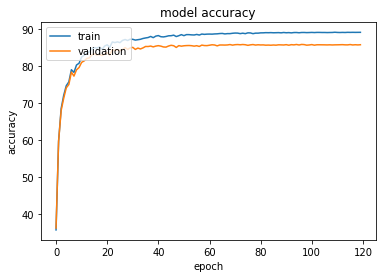

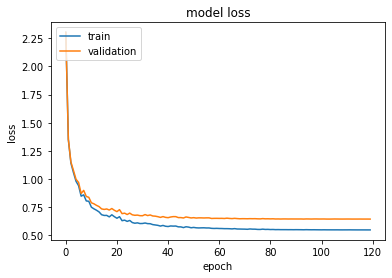

In [0]:
# Ploting code from https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy user Simone
import matplotlib.pyplot as plt

plt.plot(train_accuracy[0::3])
plt.plot(accuracy[0::3])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(train_loss[0::3])
plt.plot(loss[0::3])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [0]:
rotated_test1 = np.reshape(np.rot90(np.reshape(X_test, (10000,28,28)),1, (1,2)), (10000,28*28))
rotated_test2 = np.reshape(np.rot90(np.reshape(X_test, (10000,28,28)),2, (1,2)), (10000,28*28))
rotated_test3 = np.reshape(np.rot90(np.reshape(X_test, (10000,28,28)),3, (1,2)), (10000,28*28))


In [0]:
res = model.evaluate(rotated_test1, test_labels)
print(res[0])
res = model.evaluate(rotated_test2, test_labels)
print(res[0])
res = model.evaluate(rotated_test3, test_labels)
print(res[0])

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /content/cnn_graph/lib/../checkpoints/demo/model-72000
accuracy: 85.41 (8541 / 10000), f1 (weighted): 85.41, loss: 6.55e-01
time: 1s (wall 1s)
INFO:tensorflow:Restoring parameters from /content/cnn_graph/lib/../checkpoints/demo/model-72000
accuracy: 85.38 (8538 / 10000), f1 (weighted): 85.39, loss: 6.59e-01
time: 1s (wall 1s)
INFO:tensorflow:Restoring parameters from /content/cnn_graph/lib/../checkpoints/demo/model-72000
accuracy: 85.55 (8555 / 10000), f1 (weighted): 85.52, loss: 6.60e-01
time: 1s (wall 1s)


In [0]:
res = model.evaluate(X_test, test_labels)
print(res[0])

INFO:tensorflow:Restoring parameters from /content/cnn_graph/lib/../checkpoints/demo/model-72000
accuracy: 85.70 (8570 / 10000), f1 (weighted): 85.65, loss: 6.44e-01
time: 1s (wall 1s)


In [0]:
from google.colab import files
files.download("cnn_graph/checkpoints/demo/model-72000.meta")
files.download("cnn_graph/checkpoints/demo/model-72000.index")

In [0]:
!cp cnn_graph/checkpoints/demo/model-72000.data-00000-of-00001 ./model-72000.data-00000-of-00001